<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Evaluating Classifiers: The Confusion Matrix and AUC-ROC

---

## Learning Objectives


### Core
- Understand what true positives, false positives, true negatives, and false negatives are
- Understand what a confusion matrix is and how to apply and use it
- Calculate the most common classification evaluation metrics
    - Accuracy
    - Precision
    - Recall
    - F1
- Produce a classification report
- Plot a receiver operating characteristic (ROC) curve

### Target

- Know when you would choose to change the threshold for prediction for a classification model
- Manually change the threshold for prediction and observe the results
- Calculate the ROC-AUC score


### Stretch
- Describe what ROC curves are and why they're useful

### Lesson Guide
- [Introduction: evaluating classifiers](#intro)
- [The baseline accuracy](#baseline)
- [Build a KNN model to predict spam](#knn)
- [Predicting labels vs. predicting probabilities](#labels-vs-probs)
- [The confusion matrix](#confusion-matrix)
- [Review: Type I error and p-values](#type1-pvalues)
- [Type II error and power](#type2-power)
- [Fundamental classifier metrics](#metrics)
    - [Accuracy](#accuracy)
    - [Sensitivity / Recall / True Positive Rate (TPR)](#sensitivity)
    - [False Positive Rate (FPR)](#fpr)
    - [Specificity / True Negative Rate (TNR)](#specificity)
    - [Precision / Positive Predictive Value](#precision)
- [The F1-score and sklearn's `classification_report`](#f1-score)
- [Changing the threshold for prediction](#threshold)
    - [Load the UCI breast cancer data](#uci)
    - [Evaluate prediction on a test set](#testing)
- [The ROC curve](#roc-curve)
- [Reference table of common classification metric terms and definitions](#table)
- [Additional resources](#resources)


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)

<a id='intro'></a>

## Introduction: evaluating classifiers

---

The evaluation of classifier models is not as straightforward as for regression models. In this lesson we will cover the fundamentals of evaluating classifiers.

To ground the theory in a real world example, we will use a spam dataset to build and evaluate classifiers on. The spam dataset is 1001 columns wide, containing an `is_spam` binary marker for whether a given email was spam or not, and then 1000 columns, each corresponding to a word that could have appeared in the email (also marked with 0 or 1).

#### Load the spam data below and print out the header.

In [2]:
spam = pd.read_csv('../../../../resource-datasets/spam/spam_words_wide.csv')

In [3]:
spam.head()

,is_spam,getzed,86021,babies,sunoco,ultimately,thk,voted,spatula,fiend,...,itna,borin,thoughts,iccha,videochat,freefone,pist,reformat,strict,69698
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
spam[spam.is_spam==1].sum().sort_values(ascending=False)[:10]

is_spam    747
mobile     113
prize       84
send        70
uk          70
cash        66
urgent      62
cs          44
camera      31
cost        31
dtype: int64

In [5]:
print(spam.shape, spam.is_spam.mean())

(5572, 1001) 0.13406317300789664


In [6]:
len(spam), len(spam[spam.is_spam==1]),len(spam[spam.is_spam==0]), len(spam[spam.is_spam==1])/float(len(spam))

(5572, 747, 4825, 0.13406317300789664)

<a id='baseline'></a>

## The baseline accuracy

---

The importance of calculating your baseline accuracy when building classifiers cannot be overstated. It is critical to know the baseline when you are evaluating a classifier using accuracy.

> **Baseline Accuracy**: The accuracy that can be achieved by a model by simply guessing the majority class for every observation.

As human beings we are inclined to think that "50% accuracy" is equivalent to guessing by chance. In fact, a 50% accuracy only equates to guessing by chance in a very specific context: when we have equal proportion of positive and negative (1 and 0) target class labels in our dataset, or in the multi-class case when the majority class makes up 50% of the labels.

> **`baseline_accuracy = majority_class_N / total_N`**

In a binary class problem the reality is that your dataset is more likely to be unbalanced, and the more unbalanced it is the higher the baseline accuracy becomes. This is important to remember because if 99% of your observations are of one class, predicting 99% of them correctly with a model is performing at chance.

#### Calculate the baseline accuracy for the spam dataset

In [7]:
baseline_acc = 1. - spam.is_spam.mean()
baseline_acc

0.8659368269921034

<a id='knn'></a>

## Set up a KNN model to predict spam

---

We will use just the first 250 columns for the sake of speed in fitting and prediction. Even with a fourth of the predictors the cross-validation can be noticeably slow.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

y = spam.is_spam.values
X = spam.iloc[:, 1:251]

knn = KNeighborsClassifier()

#### Cross-validate the accuracy of the model

Use 10 folds. How does the mean performance across folds compare to the baseline accuracy?

In [15]:
from sklearn.model_selection import cross_val_score

accs = cross_val_score(knn, X, y, cv=10)
print(accs)
print(np.mean(accs))

[0.8978 0.8835 0.8889 0.8763 0.8961 0.8833 0.8923 0.8921 0.9083 0.9137]
0.8932264589671867


Classification models use stratified k-fold by default. This does maintain class balance between the different folds, however also preserves order of the observations. The explicit formulation of the last step can be achieved like the following.

In [16]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = StratifiedKFold(n_splits=10)

accs = cross_val_score(knn, X, y, cv=kf)
print(accs)
print(np.mean(accs))

[0.8978 0.8835 0.8889 0.8763 0.8961 0.8833 0.8923 0.8921 0.9083 0.9137]
0.8932264589671867


Shuffling of the dataset can be useful if the data has been arranged in a specific order. Here it hardly makes any difference.

In [17]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
accs = cross_val_score(knn, X, y, cv=kf)
print(accs)
print(np.mean(accs))

[0.8961 0.8889 0.8907 0.8853 0.8925 0.9013 0.8941 0.8975 0.8939 0.8831]
0.8923197586021064


<a id='labels-vs-probs'></a>

## Predicting labels vs. predicting probabilities

---

Sklearn classification models come with two distinct prediction functions:
1. `.predict()`: predicts the labels (classes) of observations 
2. `.predict_proba()` predicts the *probability of membership to each class*.

The `.predict()` function will return the predicted labels for a design matrix as a vector of integer labels. 

In contrast, the `.predict_proba()` function will return the probabilities as a matrix, where the columns are ordered in increasing order of the class labels (e.g. the first column is probabilities for class 0, the second column is probabilities for class 1).

#### Fit the KNN model and print out the predicted labels and predicted probabilities for a few points.

In [18]:
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [19]:
knn_predictions = knn.predict(X)
print("Class predictions:", knn_predictions[:10])

Class predictions: [0 0 0 0 0 1 0 0 0 1]


In [20]:
print("True class labels:", y[0:10])

True class labels: [0 0 1 0 0 1 0 0 1 1]


In [21]:
print("Predicted probabilities:\n", knn.predict_proba(X.iloc[0:10, :]))

Predicted probabilities:
 [[1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.2 0.8]
 [1.  0. ]
 [1.  0. ]
 [0.6 0.4]
 [0.  1. ]]


In [22]:
print("Number of classification errors:", np.abs(knn_predictions-y).sum())

Number of classification errors: 568


<a id='confusion-matrix'></a>

## The confusion matrix

---

The confusion matrix is a table representing the performance of your model to classify labels correctly.

**A confusion matrix for a binary classification task:**

|   |Predicted Positive | Predicted Negative |   
|---|---|---|
|**Actual Positive** | True Positive (TP)  | False Negative (FN)  |  
|**Actual Negative**  | False Positive (FP)  | True Negative (TN)  | 

In a binary classifier, the "true" class is typically labeled with 1 and the "false" class is labeled with 0. 

> **True Positive**: A positive class observation (1) is correctly classified as positive by the model.

> **False Positive**: A negative class observation (0) is incorrectly classified as positive.

> **True Negative**: A negative class observation is correctly classified as negative.

> **False Negative**: A positive class observation is incorrectly classified as negative.

Columns of the confusion matrix sum to the predictions by class. Rows of the matrix sum to the actual values within each class. You may encounter confusion matrices where the actual is in columns and the predicted is in the rows: the meaning is the same but the table will be reoriented.

> **Note:** Remembering what the cells in the confusion matrix represent can be a little tricky. The first word (True or False) indicates whether or not the model was correct. The second word (Positive or Negative) indicates the *model's guess* (not the actual label!).

#### Calculate the confusion matrix metrics for your model below.

In [25]:
predicted = knn.predict(X)

In [26]:
tp = np.sum((y == 1) & (predicted == 1))
fp = np.sum((y == 0) & (predicted == 1))
tn = np.sum((y == 0) & (predicted == 0))
fn = np.sum((y == 1) & (predicted == 0))
print("tp:", tp)
print("fp:", fp)
print("tn:", tn) 
print("fn:", fn)
print("Number of classification errors:", fp+fn)

tp: 274
fp: 95
tn: 4730
fn: 473
Number of classification errors: 568


#### Verify this is the same as the numbers you get from sklearn's `metrics.confusion_matrix`

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
print(confusion_matrix(y, predicted,labels=[1,0]))

[[ 274  473]
 [  95 4730]]


<a id='type1-pvalues'></a>

## Review: Type I error and p-values

---

In the context of hypothesis testing false positives and false negatives are referred to as Type I and Type II error, respectively. 

Type I error is the incorrect rejection of the null hypothesis when in fact the null hypothesis is true. This is equivalent to the false positive rate in classification: the rate of a model labeling an observation as "true" when in fact it is "false". 

Type I error directly corresponds to p-values: **the p-value is the probability of incorrectly rejecting the null hypothesis.**

## Type II error and "power"

---

Type II error, on the other hand, directly corresponds to false negatives. A Type II error in the context of hypothesis testing would be to accept the null hypothesis when in fact the alternative hypothesis is true. 

Whereas Type I error corresponds to the concept of _statistical significance_, Type II error corresponds to the concept of _statistical power._ The power of a test is:

$$ \text{power} = 1 - P(\text{Type II error}) $$

More intuitively, **power measures our ability to detect an effect that is present.**

We can visualize the ideas of significance, power, and error types in a matrix the same as our confusion matrix from above:

|   |Accept $H_0$ | Reject $H_0$ |   
|---|---|---|
|**$H_0$ is True** | P(correct) <br> _(1 - alpha)_  | P(type I error) <br> _(alpha, significance)_  |  
|**$H_0$ is False**  | P(type II error) <br> _(beta)_  | P(correct) <br> _(1 - beta, power)_ | 

## The fundamental classifier metrics

---

All metrics we use to evaluate classifiers are tied to the content of the confusion matrix. Remember that for the binary classification case we have four cells in the confusion matrix:

- **`tp`**: true positives (classifier correct; classifier guessed 1)
- **`fp`**: false positives (classifier incorrect; classifier guessed 1)
- **`tn`**: true negatives (classifier correct; classifier guessed 0)
- **`fn`**: false negatives (classifier incorrect; classifier guessed 0)

Below are the fundamental metrics that data scientists use to evaluate the performance of their classifier model.

---

<a id='accuracy'></a>

### Accuracy

With the total population as

> **`total_population = tp + fp + tn + fn`**

the accuracy can be calculated as

> **`accuracy = (tp + tn) / total_population`**

which is just the proportion of correct guesses, regardless of class. The `.score()` function attached to sklearn classification model objects defaults to returning the accuracy of the model's predictions given an `X` and `y`.

The difference between one and the accuracy is known as the **misclassification rate**, which is calculated as:

> **`misclassification_rate = (fp + fn) / total_population`**

**Calculate the accuracy using the confusion matrix cells.**
- Validate that it is the same as `metrics.accuracy_score`

In [29]:
from sklearn.metrics import accuracy_score

total_population = tp + fp + tn + fn

print(float(tp + tn) / total_population)
print(accuracy_score(y, predicted))

0.8980617372577172
0.8980617372577172


---
<a id='precision'></a>

### Precision / Positive Predictive Value

The precision measures out of all the times the classifier predicted a positive label, the true label was also positive.

> **`precision = tp / (tp + fp)`**

The idea of the classifier being _precise_ is subtly different than it being _accurate_. Precision is a measure of correctness only for its positive class predictions, whereas accuracy is a measure of correctness for all guesses.

#### Calculate the precision using the confusion matrix cells.

- Validate that this is the same as `metrics.precision_score`

In [30]:
from sklearn.metrics import precision_score

print(precision_score(y, predicted))
print(float(tp) / (tp + fp))

0.7425474254742548
0.7425474254742548


---
<a id='sensitivity'></a>

### Recall/ Sensitivity / True Positive Rate

The **recall** measures out of all the times the true label was positive, the predicted label was also positive.
 

This is alternatively known as the **sensitivity** or **true positive rate**. The three names refer to the same quantity. In most cases, we will use the name recall.

This is calculated as:

> **`recall = tp / (tp + fn)`**

#### Calculate the recall with the confusion matrix cells.

- Validate that this is the same as `metrics.recall_score`

In [31]:
from sklearn.metrics import recall_score

print(recall_score(y, predicted))
print(float(tp) / (tp + fn))

0.3668005354752343
0.3668005354752343


---
<a id='fpr'></a>

### False Positive Rate (FPR)

Alternatively, the false positive rate measures out of all the times the true label was negative, the predicted label was positive.
  

> **`fpr = fp / (tn + fp)`**

#### Calculate the FPR using the confusion matrix cells.

In [32]:
print(float(fp) / (tn + fp))

0.019689119170984457


In [33]:
# alternative way to calculate the same
1 - recall_score(y==0, predicted==0)

0.01968911917098448

---
<a id='specificity'></a>

### Specificity / True Negative Rate (TNR)

The true negative rate measures out of all the times the true label was negative, the predicted label was also negative.
 
It is the sister metric to recall, which measures the same but for positives.

> **`specificity = tn / (tn + fp)`**

**Calculate the specificity using the confusion matrix cells.**

In [34]:
specificity = float(tn) / (tn + fp)
print(specificity)

0.9803108808290155


In [35]:
# alternative way to calculate the same
recall_score(y==0, predicted==0)

0.9803108808290155

<a id='f1-score'></a>

### F1-score

---

The F1-score is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of the precision and recall metrics.  

$$ F_1 = 2 \cdot \frac{1}{\tfrac{1}{\mathrm{recall}} + \tfrac{1}{\mathrm{precision}}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

Also this score gives a number between zero and one which lies between the respective values of precision and mean.

Blending the two is useful.
By combining the two we have a measure of the classifiers' ability to find the positively labeled observations as well as how permissive it is of identification errors on those labels.

In [36]:
from sklearn.metrics import f1_score

precision_1 = float(tp)/(tp+fp)
recall_1 = float(tp)/(tp+fn)
f1_1 = 2/(1/recall_1+1/precision_1)
print(f1_1)
print(f1_score(y==1, predicted==1))

0.4910394265232975
0.4910394265232975


### Classification report

Sklearn's `metrics.classification_report` prints out the report of the three metrics precision, recall and $F_1$-score on both of the classes (or more if you have a multi-class problem). "Support" refers to the total number of observations in each class. The classification report helps diagnose the effectiveness of your classifier.

- The row labeled as 1 uses our definitions above.
- The row labeled as 0 uses the definitions above if label 0 was considered as the positive class, hence it contains the true negative rate in the recall column.
- The row labeled average reports the weighted averages across both classes.

In [37]:
from sklearn.metrics import classification_report

In [38]:
print(classification_report(y, predicted))

             precision    recall  f1-score   support

          0       0.91      0.98      0.94      4825
          1       0.74      0.37      0.49       747

avg / total       0.89      0.90      0.88      5572



In [55]:
precision_1 = precision_score(y==1, predicted==1) 
precision_0 = precision_score(y==0, predicted==0)

recall_1 = recall_score(y==1, predicted==1) 
recall_0 = recall_score(y==0, predicted==0)

f1_1 = f1_score(y==1, predicted==1)
f1_0 = f1_score(y==0, predicted==0)

average_precision = (1-baseline_acc)*precision_1+baseline_acc*precision_0
average_recall = (1-baseline_acc)*recall_1+baseline_acc*recall_0
average_f1 = (1-baseline_acc)*f1_1+baseline_acc*f1_0

print('\t Precision\t   ','Recall\t      ','F_1')
print('0\t',precision_0, recall_0, f1_0)
print('1\t',precision_1, recall_1, f1_1)
print('Avg\t',average_precision, average_recall, average_f1)

	 Precision	    Recall	       F_1
0	 0.9090909090909091 0.9803108808290155 0.9433585959313922
1	 0.7425474254742548 0.3668005354752343 0.4910394265232975
Avg	 0.8867635612334718 0.8980617372577171 0.8827192528682467


<a id='threshold'></a>

## Changing the threshold for prediction

---

The prediction of the classifier defaults to guessing the class that has the highest predicted probability. This necessarily leads to the highest possible accuracy (**only a guarantee for the training data!**). 

However, it could be the case that maximizing the accuracy is not, in fact, our ultimate goal. Consider the following scenario:

> **Cancer detection:** You have developed a classifier to detect, based on some medical measurements, whether or not a person has a cancerous tumor or not. Your classifier gets a 96% accuracy compared to a 60% baseline accuracy.

Your classifier is performing well, but what might be wrong with just maximizing the accuracy in this case? Think back to the confusion matrix and your goal (to treat cancer patients before it is too late).

### Load the UCI breast cancer data

Below we will load the medical data on breast cancer detection.

In [56]:
column_names = ['id',
                'clump_thickness',
                'cell_size_uniformity',
                'cell_shape_uniformity',
                'marginal_adhesion',
                'single_epithelial_size',
                'bare_nuclei',
                'bland_chromatin',
                'normal_nucleoli',
                'mitoses',
                'class']

bcw = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', 
                  names=column_names)

bcw['bare_nuclei'] = bcw.bare_nuclei.map(lambda x: int(x) if not x == '?' else np.nan)
bcw.dropna(inplace=True)

y = bcw['class'].map(lambda x: 1 if x == 4 else 0)
X = bcw.iloc[:, 1:-1]

#### Split the data into 66% training and 33% testing. Fit a KNN classifier with `n_neighbors=25` on the training data.

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')

#### Calculate the accuracy on the test set and compare to baseline.

In [58]:
print('Baseline:\t', 1. - np.mean(y_test))
print('Model score:\t', knn.score(X_test, y_test), end=' ')

Baseline:	 0.6548672566371682
Model score:	 0.9646017699115044 

#### Calculate the predicted labels and predicted probabilities on the test set.

In [59]:
# predicted test class:
y_pred = knn.predict(X_test)

# predicted test probability:
y_pp = knn.predict_proba(X_test)

#### Create the confusion matrix for your classfier's performance on the test set.

In [60]:
# Let's say again that we are predicting cancer based on some kind of detection measure, as before.
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_cancer', 'is_healthy'],
                         columns=['predicted_cancer','predicted_healthy'])
confusion

,predicted_cancer,predicted_healthy
is_cancer,73,5
is_healthy,3,145


<a id='change-threshold'></a>

### Lower the threshold for predicting cancer

Right now the classifier is choosing to label cancer vs. healthy based on the 0.5 predicted probability threshold. 

Say our goal was to have 0 false negatives: in other words, in no case do we want to predict the person is healthy when in fact they have cancer!

1. Create a dataframe of the predicted probabilities (class 0 and class 1 probabilities).
2. Create a new column with predicted labels where the threshold for labeling cancer/1 is 10% rather than 50%
    - In other words, the predicted probability of class 1 only needs to be greater than 0.10 for the label to be 1.
3. Recreate the confusion matrix with the predictions using the new threshold.

In [61]:
# Get the predicted probability vector and explicitly name the columns:
Y_pp = pd.DataFrame(knn.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
Y_pp.head(10)

,class_0_pp,class_1_pp
0,0.08,0.92
1,1.00,0.00
2,0.20,0.80
3,0.00,1.00
4,0.56,0.44
5,1.00,0.00
6,0.04,0.96
7,1.00,0.00
8,0.12,0.88
9,0.12,0.88


 In order to do this, we can lower the threshold for predicting class 1.
 This will reduce our false negative rate to 0, but at the expense of a higher false positive rate.

In [62]:
Y_pp['pred_class_thresh10'] = [1 if x >= 0.10 else 0 for x in Y_pp.class_1_pp.values]
Y_pp.head(50)

,class_0_pp,class_1_pp,pred_class_thresh10
0,0.08,0.92,1
1,1.00,0.00,0
2,0.20,0.80,1
3,0.00,1.00,1
4,0.56,0.44,1
5,1.00,0.00,0
6,0.04,0.96,1
7,1.00,0.00,0
8,0.12,0.88,1
9,0.12,0.88,1


In [63]:
conmat = np.array(confusion_matrix(y_test, Y_pp.pred_class_thresh10.values, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_cancer', 'is_healthy'],
                         columns=['predicted_cancer','predicted_healthy'])
confusion

,predicted_cancer,predicted_healthy
is_cancer,77,1
is_healthy,6,142


<a id='roc-curve'></a>

## The Receiver operating characteristic (ROC) curve

---

The ROC curve is a popular visual of the performance of a classifier. It has a few attractive properties:
- It plots the **true positive rate (TPR)** versus the **false positive rate (FPR)** as the threshold for predicting 1 changes.
- We measure the area under the curve.
- If the TPR is always 1, the area under the curve is 1 (it cannot be larger). This is equivalent to perfect prediction.
- When the area under the curve is 0.50, this is equivalent to the baseline (chance) prediction.
- If the area is smaller than 0.5, it would be better to swap the predicted labels. 

Even though the area under the ROC curve is directly related to the accuracy, the AUC-ROC is preferred over the accuracy because it is automatically adjusted to the baseline and gives a robust picture of how the classifier performs at different threshold choices. 

**Note:**
- As the class assignment threshold increases for the positive class (has cancer), the false positive rate and true positive rate necessarily increase.
- A classifier performing at chance corresponds to the diagonal dotted line: an equal chance of false positives and true positives.
- The greater the area under the curve, the higher the ratio of true positives to false positives as the threshold becomes more lenient.
- The greater the area under the curve, the higher the quality of the classification model. 
- Most classification problems will never get close to a full 1.0 area under the curve: the Wisconsin breast cancer data is unique in that the signal is extremely strong. If you see this, it often indicates that something is wrong with your procedure (or, if you are predicting on the training set, that your model is overfitting.)

### Below is code to plot the ROC curve for our cancer data.

In [64]:
from sklearn.metrics import roc_curve, auc

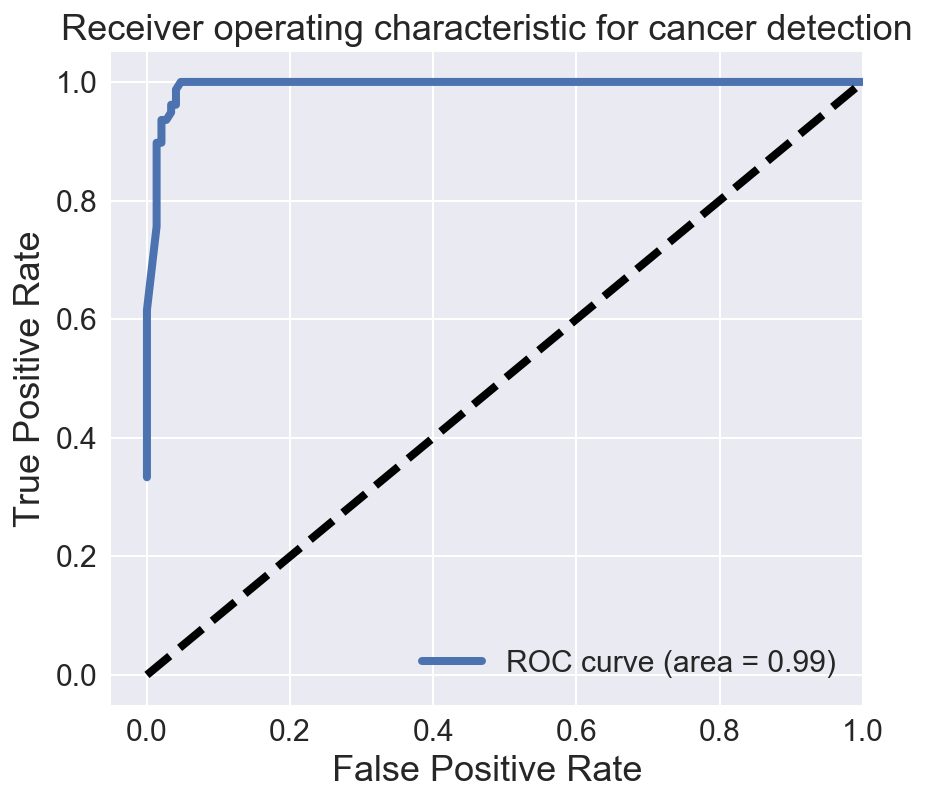

In [65]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<a id='table'></a>

In [66]:
print('fpr\t', 'tpr\t', 'threshold')
print(np.array(list(zip(fpr,tpr,threshold))))

fpr	 tpr	 threshold
[[0.     0.3333 1.    ]
 [0.     0.6154 0.96  ]
 [0.0135 0.7564 0.92  ]
 [0.0135 0.8846 0.88  ]
 [0.0135 0.8974 0.84  ]
 [0.0203 0.8974 0.8   ]
 [0.0203 0.9231 0.68  ]
 [0.0203 0.9359 0.52  ]
 [0.027  0.9359 0.44  ]
 [0.0338 0.9487 0.4   ]
 [0.0338 0.9615 0.32  ]
 [0.0405 0.9615 0.24  ]
 [0.0405 0.9872 0.12  ]
 [0.0473 1.     0.08  ]
 [0.0541 1.     0.04  ]
 [1.     1.     0.    ]]


---

## Reference table of common classification metric terms and definitions

<br><br>

|  TERM | DESCRIPTION  |
|---|---|
|**TRUE POSITIVES** | The number of "true" classes correctly predicted to be true by the model. <br><br> `TP = Sum of observations predicted to be 1 that are actually 1`<br><br>The true class in a binary classifier is labeled with 1.|
|**TRUE NEGATIVES** | The number of "false" classes correctly predicted to be false by the model. <br><br> `TN = Sum of observations predicted to be 0 that are actually 0`<br><br>The false class in a binary classifier is labeled with 0.|
|**FALSE POSITIVES** | The number of "false" classes incorrectly predicted to be true by the model. This is the measure of **Type I error**.<br><br> `FP = Sum of observations predicted to be 1 that are actually 0`<br><br>Remember that the "true" and "false" refer to the veracity of your guess, and the "positive" and "negative" component refer to the guessed label.|
|**FALSE NEGATIVES** | The number of "true" classes incorrectly predicted to be false by the model. This is the measure of **Type II error.**<br><br> `FN = Sum of observations predicted to be 0 that are actually 1`<br><br>|
|**TOTAL POPULATION** | In the context of the confusion matrix, the sum of the cells. <br><br> `total population = TP + TN + FP + FN`<br><br>|
|**SUPPORT** | The marginal sum of rows in the confusion matrix, or in other words the total number of observations belonging to a class regardless of prediction. <br><br>|
|**ACCURACY** | The number of correct predictions by the model out of the total number of observations. <br><br> `accuracy = (TP + TN) / total_population`<br><br>|
|**PRECISION** | The ability of the classifier to avoid labeling a class as a member of another class. <br><br> `Precision = TP / (TP + FP)`<br><br>_A precision score of 1 indicates that the classifier never mistakenly classified the current class as another class.  precision score of 0 would mean that the classifier misclassified every instance of the current class_ |
|**RECALL/SENSITIVITY/TRUE POSITIVE RATE**    | The ability of the classifier to correctly identify the current class. <br><br>`Recall = TP / (TP + FN)`<br><br>A recall of 1 indicates that the classifier correctly predicted all observations of the class.  0 means the classifier predicted all observations of the current class incorrectly.|
|**SPECIFICITY** | Percent of times the classifier predicted 0 out of all the times the class was 0.<br><br> `specificity = TN / (TN + FP)`<br><br>|
|**FALSE POSITIVE RATE** | Percent of times model predicts 1 when the class is 0.<br><br> `fpr = FP / (TN + FP)`<br><br>|
|**F1-SCORE** | The harmonic mean of precision and recall. The harmonic mean is used here rather than the more conventional arithmetic mean because the harmonic mean is more appropriate for averaging rates. <br><br>`F1-Score = 2 * (Precision * Recall) / (Precision + Recall)` <br><br>_The f1-score's best value is 1 and the worst value is 0, like the precision and recall scores. It is a useful metric for taking into account both measures at once._ |

<a id='resources'></a>

## Additional resources

---

- An introduction to [Confusion Matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
- A deeper [Introduction to ROC](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf)
- Receiver Operation Characteristic curves, [university resource](http://ebp.uga.edu/courses/Chapter%204%20-%20Diagnosis%20I/8%20-%20ROC%20curves.html)
- Interactive [playing with ROC curves](http://www.navan.name/roc/)
- Data School's video and transcript on [ROC/AUC](http://www.dataschool.io/roc-curves-and-auc-explained/)
- Watch Rahul Patwari's [video](https://www.youtube.com/watch?v=21Igj5Pr6u4) on ROC curves